In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import optim

import cv2 as cv
import matplotlib.pyplot as plt


### check an example image 

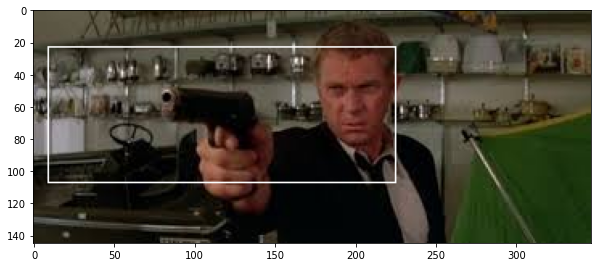

In [3]:
sample = cv.imread('../input/guns-object-detection/Images/1.jpeg')
sample = cv.cvtColor(sample,cv.COLOR_BGR2RGB)
cv.rectangle(sample, (9,23), (225,107), (255,255,255))
plt.figure(figsize=(10,6))
plt.imshow(sample) #cv.imshow does not seem to work in kaggle. 

From the above image, we can see that the labels are in the form: x1 y1 x2 y2 <br>
The label for this image is: <br>
1 <br>
9 23 225 107

In [4]:
class GunDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        
    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, f'{index+1}.jpeg') # index+1 because the filenames start with 1.jpeg and 1.txt
        image = plt.imread(image_path)
        
        label_path = os.path.join(self.labels_dir, f'{index+1}.txt')
        with open(label_path, 'r') as file:
        #     print(file.read())
            lines = file.readlines()
            bbox = lines[1]
            bbox = bbox[:-1]
            x1, y1, x2, y2 = bbox.split(' ')
            
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        x1, y1, x2, y2 = torch.tensor(x1), torch.tensor(y1), torch.tensor(x2), torch.tensor(y2)            
        bbox = [x1, y1, x2, y2]
        
        return image, bbox
        
    def __len__(self):
        return len(os.listdir(self.images_dir))

In [5]:
dataset = GunDataset(images_dir='../input/guns-object-detection/Images/', labels_dir='../input/guns-object-detection/Labels/')

In [6]:
dataloader = DataLoader(dataset, 1, shuffle=True)

In [7]:
next(iter(dataloader))

[tensor([[[[44, 53, 48],
           [47, 56, 51],
           [49, 58, 53],
           ...,
           [32, 33, 28],
           [32, 33, 27],
           [34, 35, 29]],
 
          [[44, 53, 48],
           [47, 56, 51],
           [49, 58, 53],
           ...,
           [21, 22, 17],
           [22, 23, 17],
           [24, 25, 19]],
 
          [[44, 53, 48],
           [47, 56, 51],
           [49, 58, 53],
           ...,
           [30, 31, 25],
           [31, 32, 26],
           [32, 33, 27]],
 
          ...,
 
          [[ 6,  6,  6],
           [ 6,  6,  6],
           [ 6,  6,  6],
           ...,
           [13, 13, 11],
           [13, 13, 11],
           [13, 13, 11]],
 
          [[ 5,  5,  5],
           [ 5,  5,  5],
           [ 6,  6,  6],
           ...,
           [13, 13, 11],
           [13, 13, 11],
           [13, 13, 11]],
 
          [[ 5,  5,  5],
           [ 6,  6,  6],
           [ 6,  6,  6],
           ...,
           [11, 11,  9],
           [12, 12, 10

### Create a function to visualize the returned value of the dataloader

In [8]:
def viz():
    dloader = DataLoader(dataset, 1, shuffle=True)
    sampimage, samplabel = next(iter(dloader))
    cvrect = cv.rectangle(sampimage[0].numpy(), (samplabel[0].item(), samplabel[1].item()), (samplabel[2].item(), samplabel[3].item()), (255,255,255))
    plt.imshow(sampimage[0])

### visualize a few examples (results are before adding transform to the dataset)

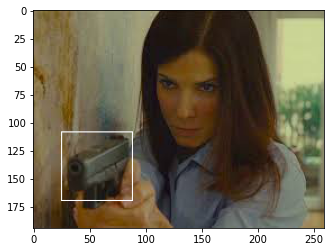

In [9]:
viz()

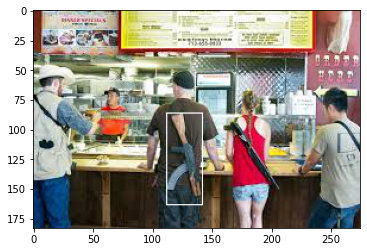

In [10]:
viz()

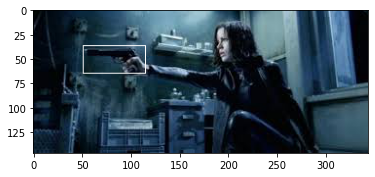

In [11]:
viz()

We can see that the dataloader returns that image and the bboxes correctly

### now that we have visualized the dataset output, we can add the transform to the dataset. transform wasnt added before because after resize, we wouldnt have been able to plot bboxes   

In [12]:
transform = transforms.Compose([transforms.Grayscale(),
                               transforms.Resize((150,150)),
                               transforms.ToTensor()])

In [13]:
from PIL import Image

In [14]:
class GunDatasetT(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        
    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, f'{index+1}.jpeg') # index+1 because the filenames start with 1.jpeg and 1.txt
        image = Image.open(image_path) # for transform to work, the input should be a PIL image
        image = transform(image)
        
        label_path = os.path.join(self.labels_dir, f'{index+1}.txt')
        with open(label_path, 'r') as file:
        #     print(file.read())
            lines = file.readlines()
            bbox = lines[1]
            bbox = bbox[:-1]
            x1, y1, x2, y2 = bbox.split(' ')
            
        x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
        bbox = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
        
        return image, bbox, image_path # image path will be used while testing, when we graph the image and the predicted bbox 
        
    def __len__(self):
        return len(os.listdir(self.images_dir))

In [15]:
dataset = GunDatasetT(images_dir='../input/guns-object-detection/Images/', labels_dir='../input/guns-object-detection/Labels/')

### visualize after transformation 

In [16]:
def vizt():
    dloader = DataLoader(dataset, 1, shuffle=True)
    sampimage, samplabel, _ = next(iter(dloader))
    print(sampimage.shape)
#     cvrect = cv.rectangle(sampimage[0].numpy(), (samplabel[0].item(), samplabel[1].item()), (samplabel[2].item(), samplabel[3].item()), (255,255,255))
    sampimage = torch.permute(sampimage[0], (1,2,0)) # permute back to HxWxC to show in plt.imshow 
    plt.imshow(sampimage)
    print(samplabel)

torch.Size([1, 1, 150, 150])
tensor([[113.,  47., 251.,  94.]])


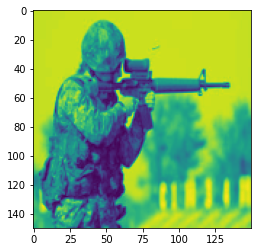

In [17]:
vizt()

### split into train and test datasets

In [18]:
from torch.utils.data import random_split

In [19]:
trainlen = int(0.8 * len(dataset))
testlen = len(dataset) - trainlen
trainlen, testlen

(266, 67)

In [20]:
traindataset, testdataset = random_split(dataset, (trainlen, testlen))

### Create a model 

In [21]:
class Model1(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 9 * 9, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.lin3 = nn.Linear(4096, 4)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)
#         print(x.shape)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)
#         print(x.shape)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)
#         print(x.shape)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
#         print(x.shape)
        
        # x = x.view(-1, 512 * 2 * 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)
        
        return x

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
torch.cuda.is_available()

True

In [24]:
model = Model1().to(device)

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [26]:
epochs = 50
batch_size = 20

In [27]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)

In [28]:
next(iter(trainloader))[0].shape

torch.Size([20, 1, 150, 150])

In [29]:
running_loss = []
print_every = 10

for e in range(epochs):
    for i,(images,labels,_) in enumerate(trainloader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        if(i%print_every == 0):
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item()}')
        
        

epoch: 0, iteration: 0, loss: 15452.296875
epoch: 0, iteration: 10, loss: 2455.534423828125
epoch: 1, iteration: 0, loss: 5719.31787109375
epoch: 1, iteration: 10, loss: 3125.16015625
epoch: 2, iteration: 0, loss: 3142.549560546875
epoch: 2, iteration: 10, loss: 2416.932373046875
epoch: 3, iteration: 0, loss: 2064.400146484375
epoch: 3, iteration: 10, loss: 2909.988525390625
epoch: 4, iteration: 0, loss: 2809.971435546875
epoch: 4, iteration: 10, loss: 2269.71435546875
epoch: 5, iteration: 0, loss: 2087.01171875
epoch: 5, iteration: 10, loss: 2017.8629150390625
epoch: 6, iteration: 0, loss: 1551.2281494140625
epoch: 6, iteration: 10, loss: 2125.984619140625
epoch: 7, iteration: 0, loss: 2121.010498046875
epoch: 7, iteration: 10, loss: 2170.421630859375
epoch: 8, iteration: 0, loss: 2036.0062255859375
epoch: 8, iteration: 10, loss: 1678.5023193359375
epoch: 9, iteration: 0, loss: 1572.5859375
epoch: 9, iteration: 10, loss: 1703.287353515625
epoch: 10, iteration: 0, loss: 2636.2077636718

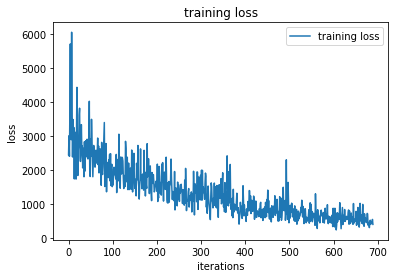

In [30]:
ind = 10
plt.plot(np.arange(len(running_loss[ind:])), running_loss[ind:], label='training loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('training loss')
plt.legend()
plt.show()

### test an image 

In [31]:
testloader = DataLoader(testdataset, 1, shuffle=True)

In [32]:
model.eval()
with torch.no_grad():
    testimage, testlabel, image_path = next(iter(testloader))
    testimage = testimage.to(device)
    testlabel = testlabel.to(device)
    testout = model(testimage)
testout, testlabel

(tensor([[121.8222,  55.0768, 198.7897, 142.2123]], device='cuda:0'),
 tensor([[ 22., 102., 288., 162.]], device='cuda:0'))

In [33]:
testout.cpu().numpy()[0]

array([121.822235,  55.076813, 198.78972 , 142.21234 ], dtype=float32)

In [34]:
image_path # pytorch dataset automatically puts the string in a tuple

('../input/guns-object-detection/Images/180.jpeg',)

predicted bbox in blue and label in green


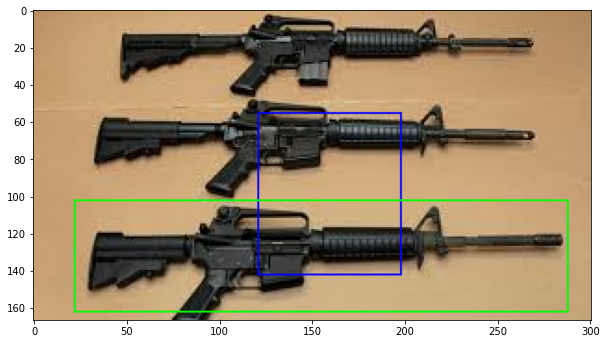

In [35]:
sample = cv.imread(image_path[0])
sample = cv.cvtColor(sample,cv.COLOR_BGR2RGB)
cv.rectangle(sample, (int(testout.cpu().numpy()[0][0]),int(testout.cpu().numpy()[0][1])), (int(testout.cpu().numpy()[0][2]),int(testout.cpu().numpy()[0][3])), (0,0,255))
cv.rectangle(sample, (int(testlabel.cpu().numpy()[0][0]),int(testlabel.cpu().numpy()[0][1])), (int(testlabel.cpu().numpy()[0][2]),int(testlabel.cpu().numpy()[0][3])), (0,255,0))
plt.figure(figsize=(10,6))
plt.imshow(sample) #cv.imshow does not seem to work in kaggle. 
print('predicted bbox in blue and label in green')

### create a function to visualize several test outputs

In [36]:
def viz_output():
    model.eval()
    with torch.no_grad():
        testimage, testlabel, image_path = next(iter(testloader))
        testimage = testimage.to(device)
        testlabel = testlabel.to(device)
        testout = model(testimage)
    testout, testlabel
    sample = cv.imread(image_path[0])
    sample = cv.cvtColor(sample,cv.COLOR_BGR2RGB)
    cv.rectangle(sample, (int(testout.cpu().numpy()[0][0]),int(testout.cpu().numpy()[0][1])), (int(testout.cpu().numpy()[0][2]),int(testout.cpu().numpy()[0][3])), (0,0,255))
    cv.rectangle(sample, (int(testlabel.cpu().numpy()[0][0]),int(testlabel.cpu().numpy()[0][1])), (int(testlabel.cpu().numpy()[0][2]),int(testlabel.cpu().numpy()[0][3])), (0,255,0))
    plt.figure(figsize=(10,6))
    plt.imshow(sample) #cv.imshow does not seem to work in kaggle. 
    print('predicted bbox in blue and label in green')

predicted bbox in blue and label in green


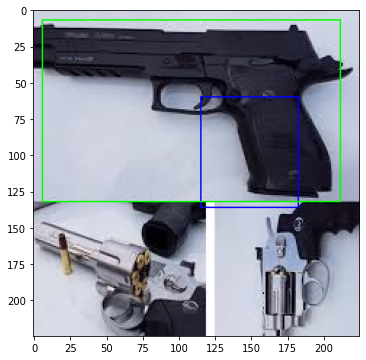

In [37]:
viz_output()

predicted bbox in blue and label in green


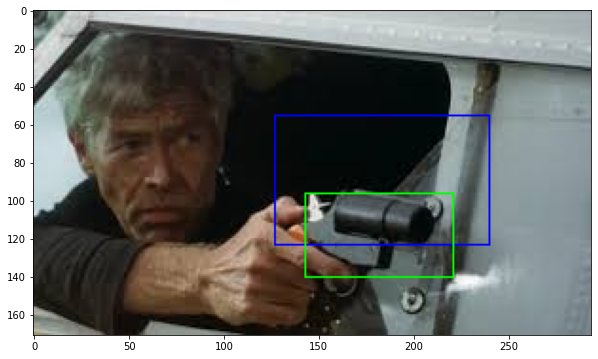

In [38]:
viz_output()

predicted bbox in blue and label in green


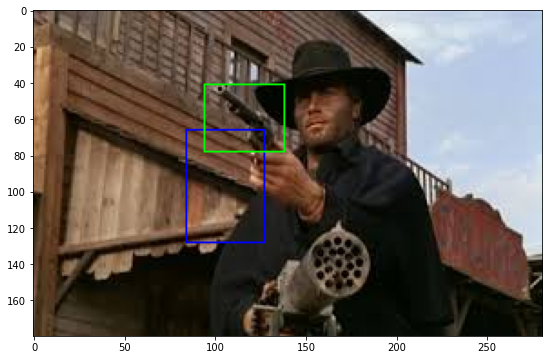

In [39]:
viz_output()

predicted bbox in blue and label in green


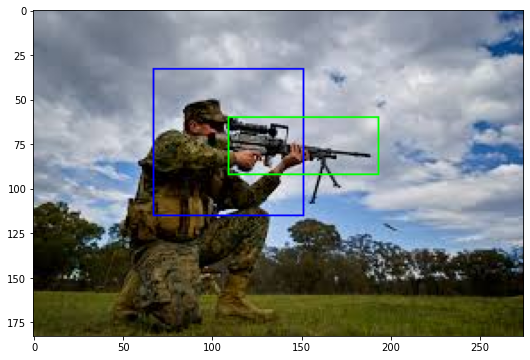

In [40]:
viz_output()

### Conclusion 

The object localization model seems to work fairly well. *no data augmentation or hyperparameter optimization was done

### appendix 

In [41]:
model

Model1(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [42]:
samploader = DataLoader(traindataset, 1)
images, labels, _ = next(iter(samploader)) 
images = images.to(device)
labels = labels.to(device)
model(images)

tensor([[208.2872,  82.7861, 279.9887, 132.2147]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [43]:
labels

tensor([[222.,  95., 286., 130.]], device='cuda:0')

In [44]:
labels.dtype

torch.float32

In [45]:
dataset = GunDataset(images_dir='../input/guns-object-detection/Images/', labels_dir='../input/guns-object-detection/Labels/')
dloader = DataLoader(dataset, 1, shuffle=True)
sampimage, samplabel = next(iter(dloader))
samplabel

[tensor([29]), tensor([60]), tensor([194]), tensor([109])]

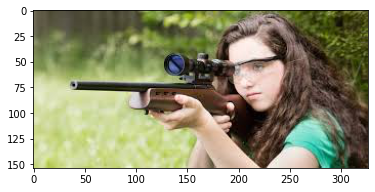

In [46]:
plt.imshow(sampimage[0])

In [47]:
sampimage[0].shape

torch.Size([154, 327, 3])

In [48]:
sampimage = torch.permute(sampimage[0], (2,0,1))

In [49]:
sampimage.shape

torch.Size([3, 154, 327])

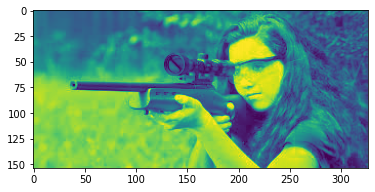

In [50]:
plt.imshow(sampimage[0]) #for plt to show all channels, the format should be HxWxC, but we have converted it to CxHxW

In [51]:
len(os.listdir('../input/guns-object-detection/Images/'))

333

In [52]:
with open('../input/guns-object-detection/Labels/1.txt', 'r') as file:
#     print(file.read())
    lines = file.readlines()
    bbox = lines[1]
    bbox = bbox[:-1]
    x1, y1, x2, y2 = bbox.split(' ')

In [53]:
lines, bbox, x1, y1, x2, y2

(['1\n', '76 45 146 87\n'], '76 45 146 87', '76', '45', '146', '87')